# PGCs and MYC samples trajectories with DPT
Using Chloe data as well

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.set_figure_params(dpi_save=320,format='tiff')
sc.settings.autosave=True

In [4]:
results_file = './write/PGCs_MYC_SPINtrajectory.h5ad'

### Read PGCs and MYC-IC data

In [5]:
rds_path = '../../../../scRNAseq_Ranalysis/Seurat_v3/trajectories/PGCs/'

In [6]:
%%R -i rds_path -o pgc_marioni -o pgc_chloe -o myc

pgc_marioni = readRDS(paste0(rds_path,'pgc_marioni_py.rds'))
pgc_chloe = readRDS(paste0(rds_path, 'pgc_chloe_py.rds'))
myc = readRDS(paste0(rds_path,'MYC_spin_py.rds'))

In [7]:
# Concatenate to unique adata object
adata = pgc_marioni.concatenate([pgc_chloe, myc], batch_key='batch_conc',
                                                        index_unique=None)

In [8]:
adata

AnnData object with n_obs × n_vars = 15624 × 14317 
    obs: 'CellType', 'batch', 'batch_conc', 'cell', 'celltype', 'doublet_scores', 'ident', 'index', 'integrated_snn_res.0.5', 'localization', 'louvain_bbknn', 'louvain_pgcs', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'new_clustering', 'orig', 'orig.ident', 'percent.mt', 'predOrd_CV', 'predicted_doublets', 'rep', 'sample', 'sequencing.batch', 'seurat_clusters', 'sex', 'sex_time', 'stage', 'subgroup', 'time'
    layers: 'logcounts'

In [9]:
adata.obs.head()

,CellType,batch,batch_conc,cell,celltype,doublet_scores,ident,index,integrated_snn_res.0.5,localization,...,predicted_doublets,rep,sample,sequencing.batch,seurat_clusters,sex,sex_time,stage,subgroup,time
cell_394,NaN,marioni,0,cell_394,PGC,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,E7.5,NaN,NaN
cell_477,NaN,marioni,0,cell_477,PGC,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,E7.5,NaN,NaN
cell_717,NaN,marioni,0,cell_717,PGC,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,E7.5,NaN,NaN
cell_745,NaN,marioni,0,cell_745,PGC,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,E7.5,NaN,NaN
cell_1005,NaN,marioni,0,cell_1005,PGC,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,E7.5,NaN,NaN


In [10]:
adata.obs.dtypes

CellType                    object
batch                       object
batch_conc                category
cell                        object
celltype                    object
doublet_scores             float64
ident                        int32
index                      float64
integrated_snn_res.0.5     float64
localization                object
louvain_bbknn              float64
louvain_pgcs               float64
nCount_RNA                 float64
nFeature_RNA                 int32
nGene                      float64
nUMI                       float64
new_clustering             float64
orig                       float64
orig.ident                  object
percent.mt                 float64
predOrd_CV                 float64
predicted_doublets         float64
rep                        float64
sample                      object
sequencing.batch           float64
seurat_clusters            float64
sex                         object
sex_time                   float64
stage               

In [31]:
#adata.obs['stage'] = adata.obs['stage'].astype('category')

### Normalization

In [11]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 14317
filtered out 88 genes that are detectedin less than 20 cells
Number of genes after cell filter: 14229


In [12]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

#Normalize adata 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


### Use BBKNN to correct for batch effects

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:31)


In [17]:
set(adata.obs['batch'])

{'MYC-spinal', 'marioni', 'mayere'}

In [18]:
sc.external.pp.bbknn(adata, batch_key='batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:09)


In [19]:
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99539757 0.99331737 0.99144924 0.9891676  0.988869
     0.9881191  0.987976   0.98725337 0.98605907 0.9860147  0.9859198
     0.98562056 0.9846765  0.98404896]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:35)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:06:32)


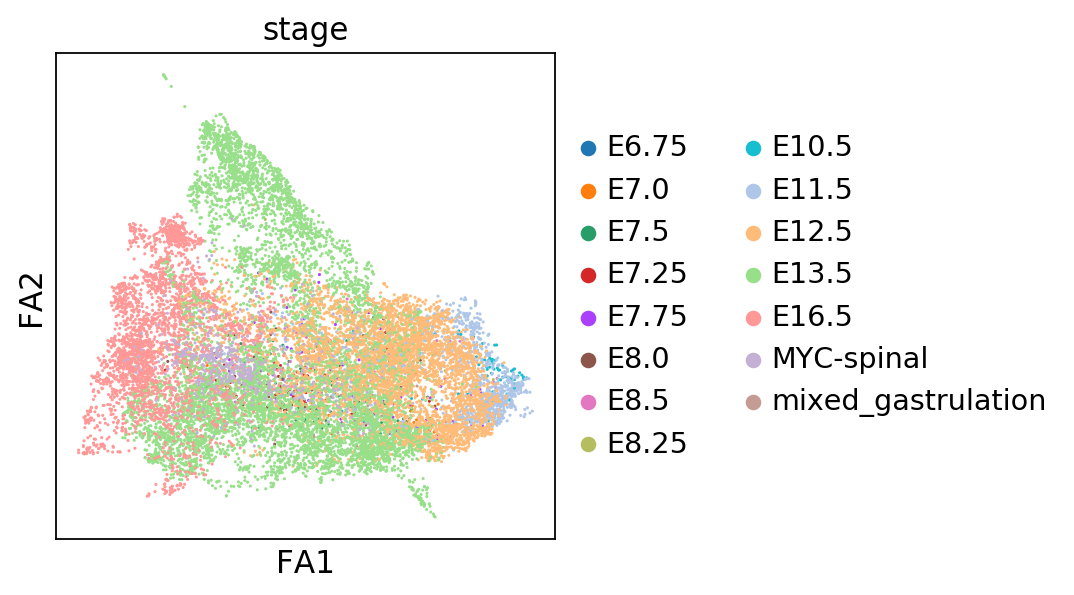

In [25]:
sc.pl.draw_graph(adata, color='stage', save = '_pgc_mycspin_stage')

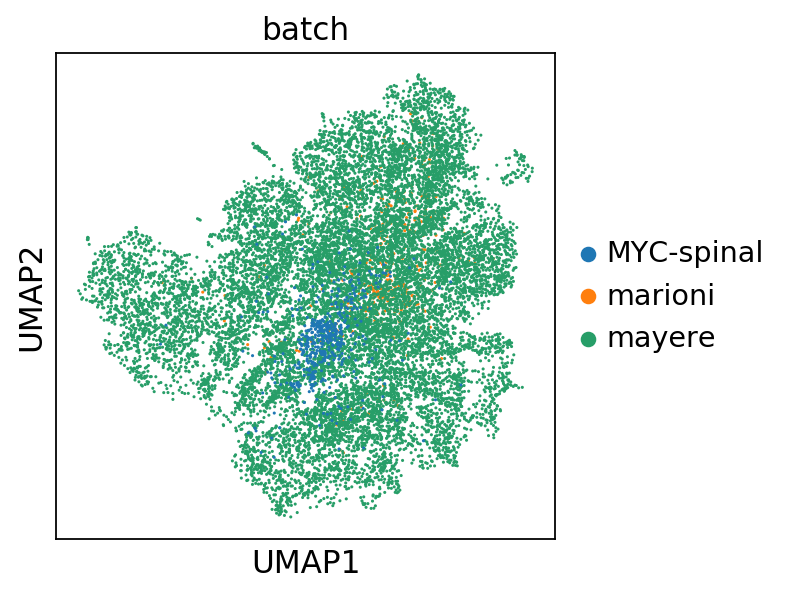

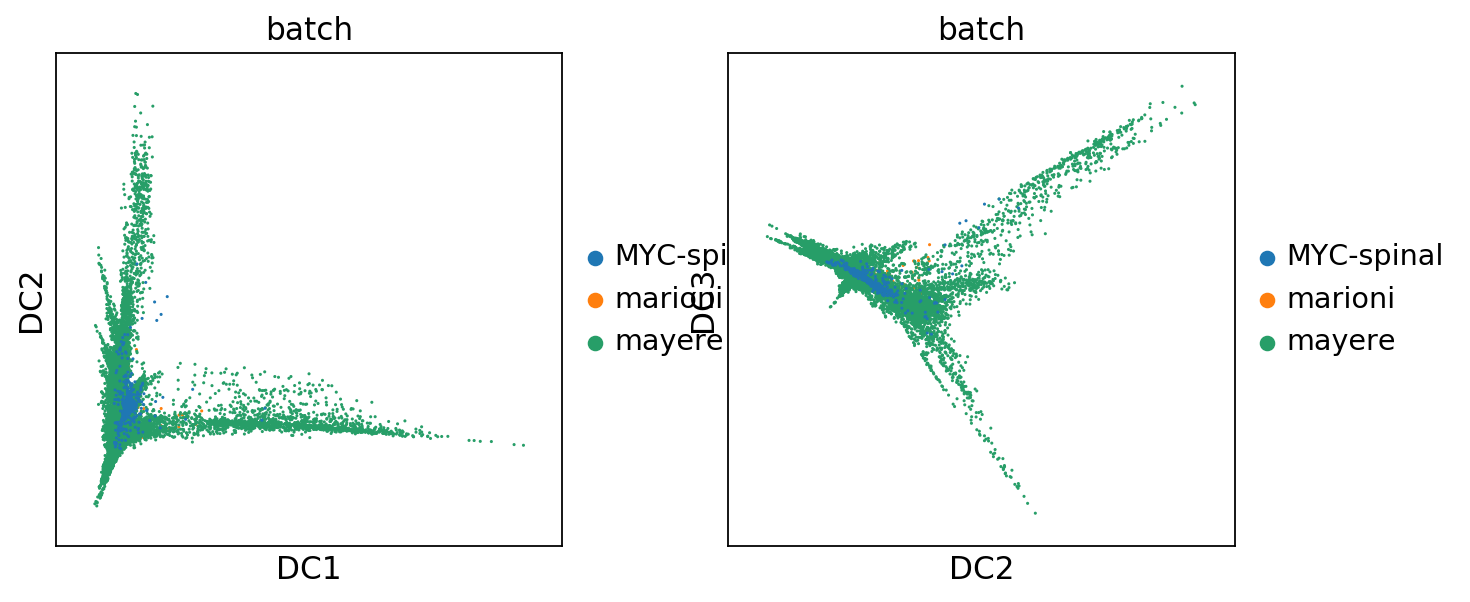

In [26]:
sc.pl.umap(adata, color = 'batch', save = '_pgc_mycspin_batch')
sc.pl.diffmap(adata, components=['1,2','2,3'], color='batch', save = '_pgc_mycspin_batch')

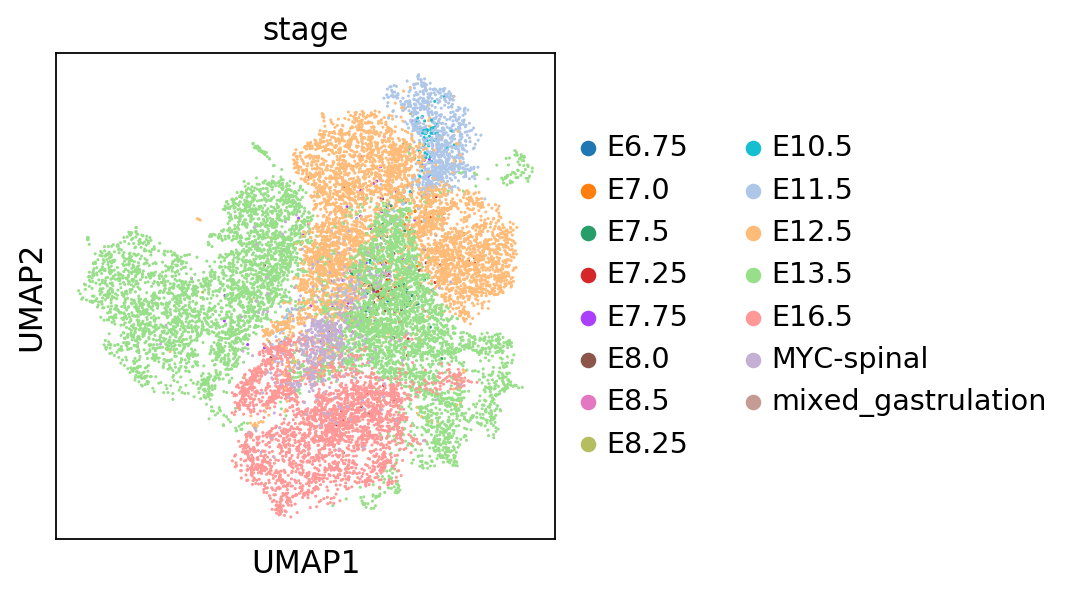

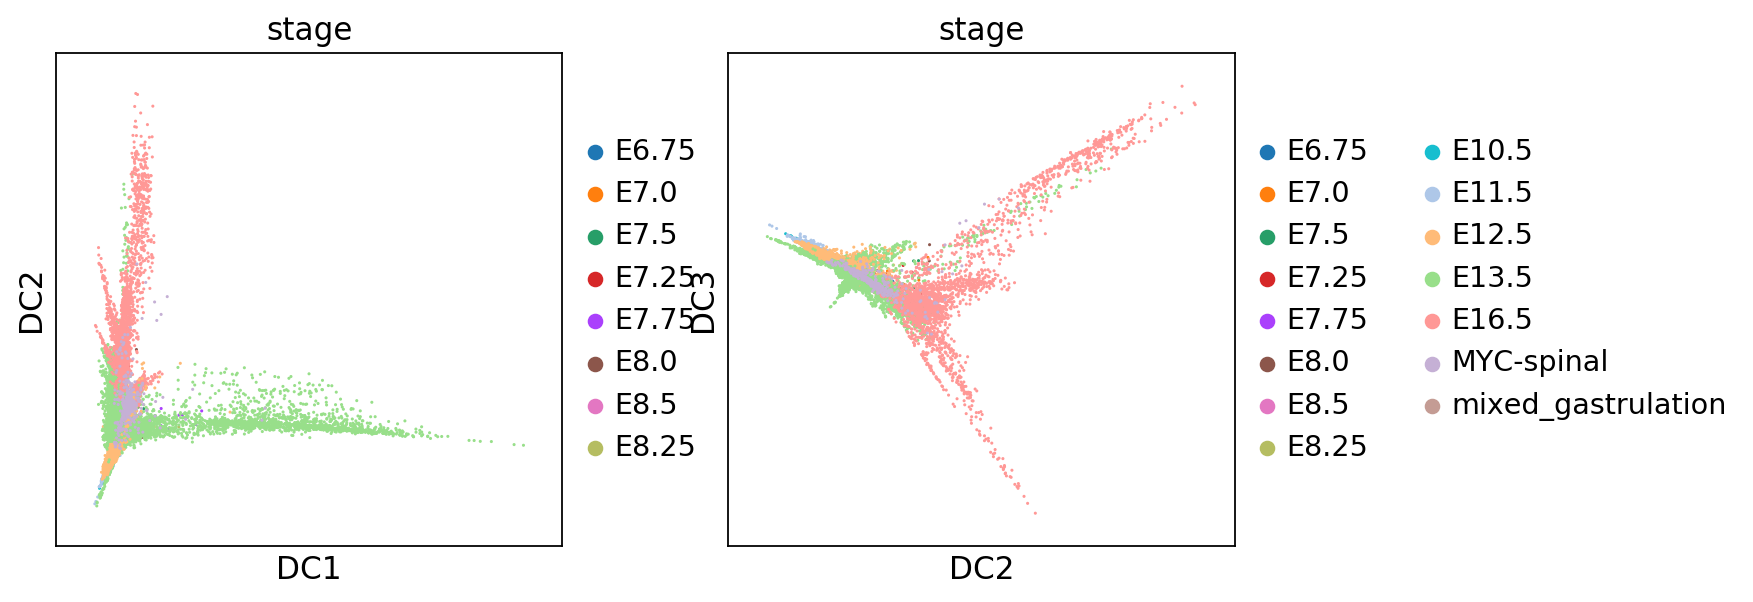

In [27]:
sc.pl.umap(adata, color = 'stage', save = '_pgc_mycspin_stage')
sc.pl.diffmap(adata, components=['1,2','2,3'], color='stage', save = '_pgc_mycspin_stage')

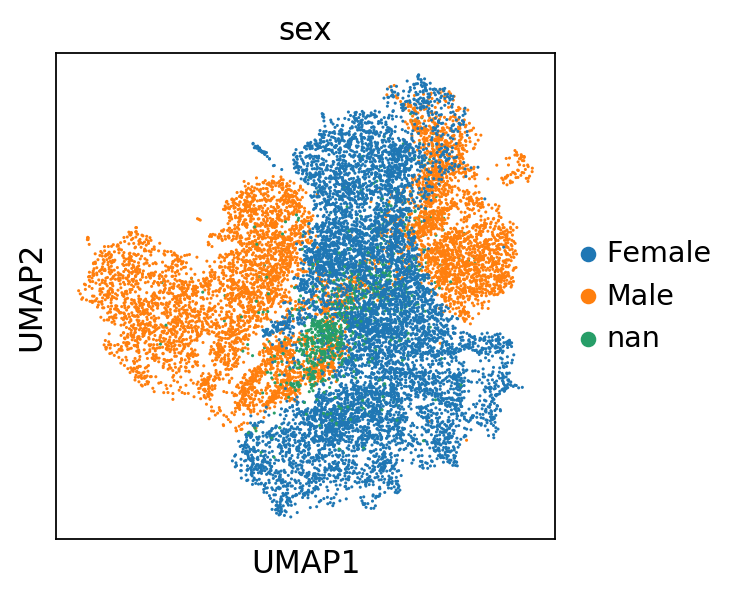

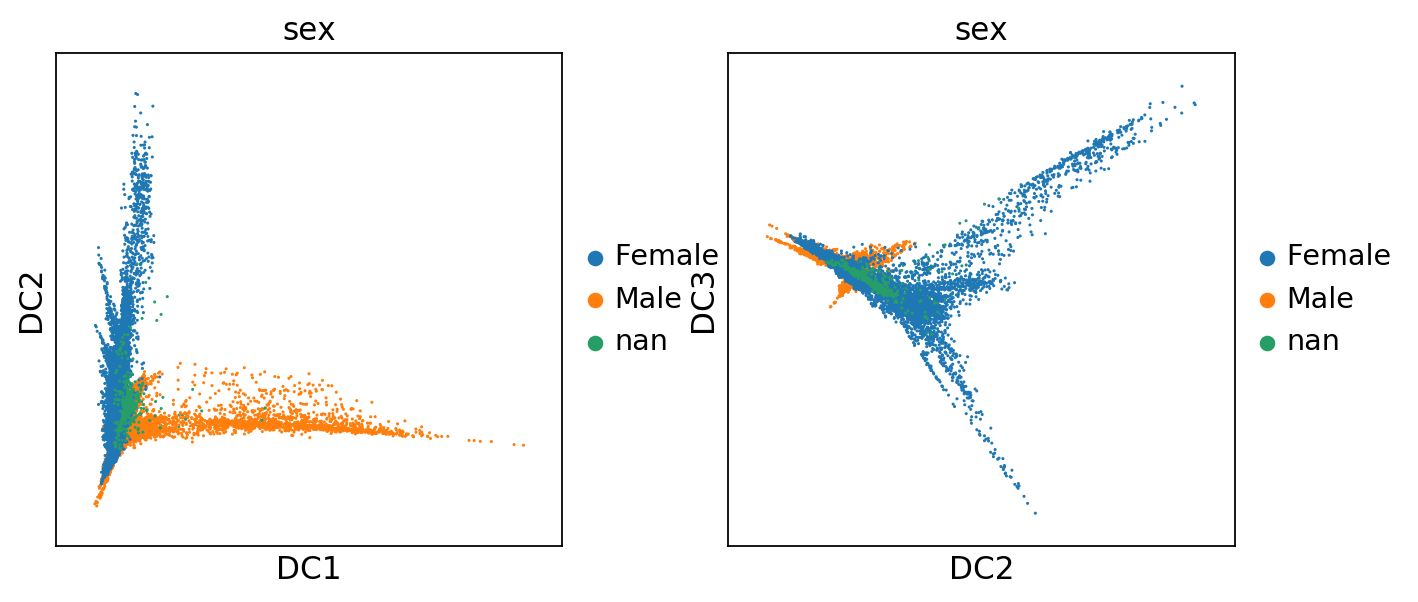

In [28]:
sc.pl.umap(adata, color = 'sex', save = '_pgc_mycspin_sex')
sc.pl.diffmap(adata, components=['1,2','2,3'], color='sex', save = '_pgc_mycspin_sex')

# denoise the graph as in tutorial trajectory

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)


In [30]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:06:12)


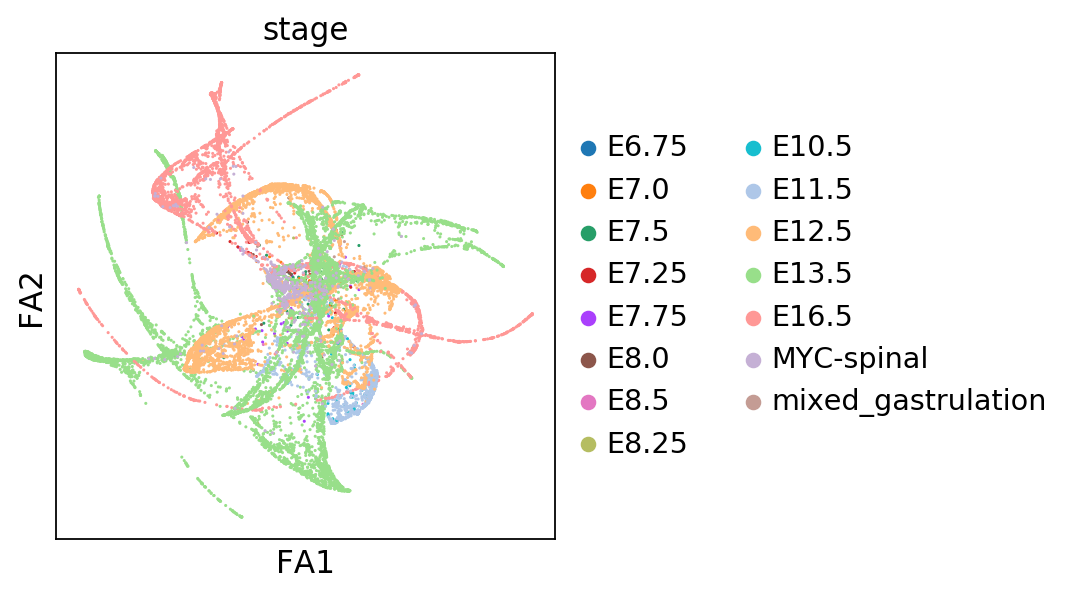

In [31]:
sc.pl.draw_graph(adata, color='stage', save = '_pgc_mycspin_stage_diffmapINI')

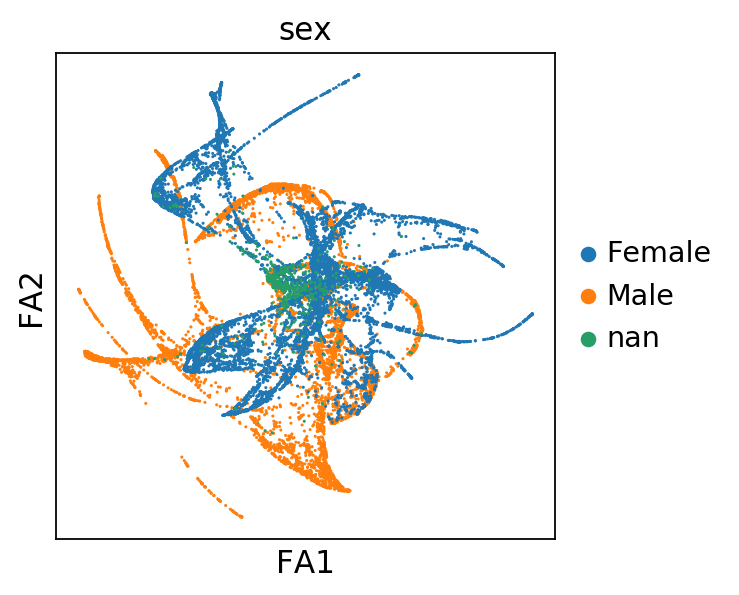

In [32]:
sc.pl.draw_graph(adata, color='sex', save = '_pgc_mycspin_sex_diffmapINI')

# clustering and paga

In [38]:
sc.tl.louvain(adata, resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


In [39]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)


/opt/conda/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


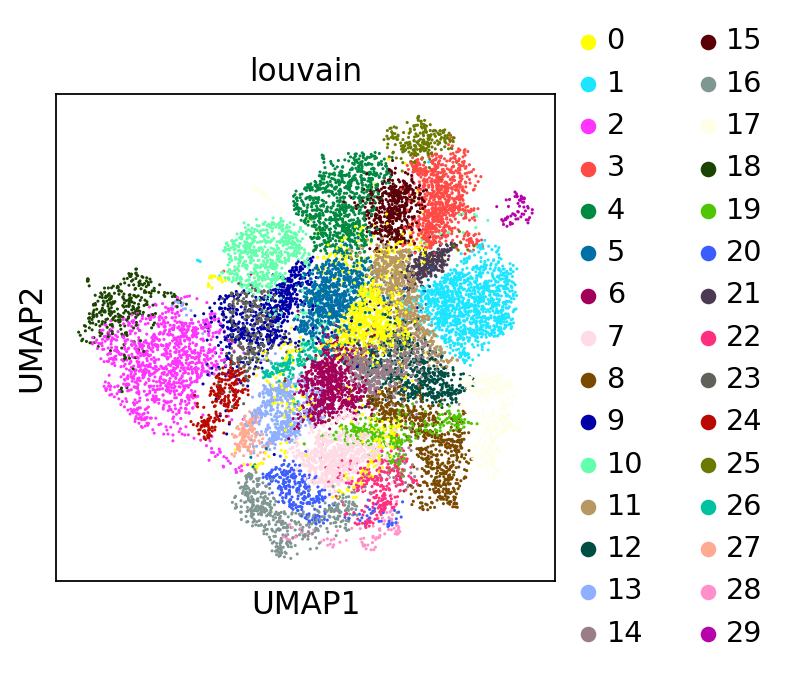

In [40]:
sc.pl.umap(adata, color='louvain')

--> added 'pos', the PAGA positions (adata.uns['paga'])


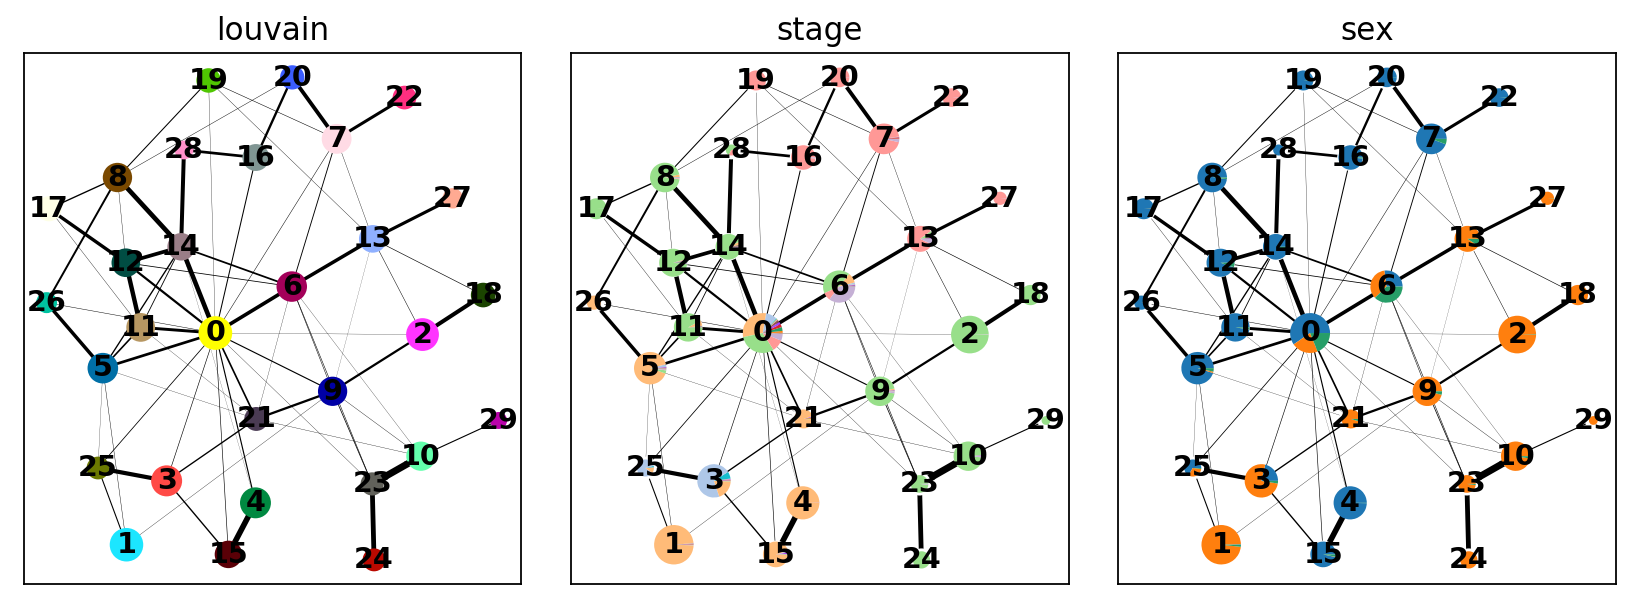

In [43]:
sc.pl.paga(adata, color=['louvain', 'stage', 'sex'])

In [26]:
# Calculate pseudotime with DPT
adata.uns['iroot'] = np.flatnonzero(adata.obs['stage'] == 'E6.75')[0]
sc.tl.dpt(adata, n_branchings=1, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:00)


/opt/conda/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


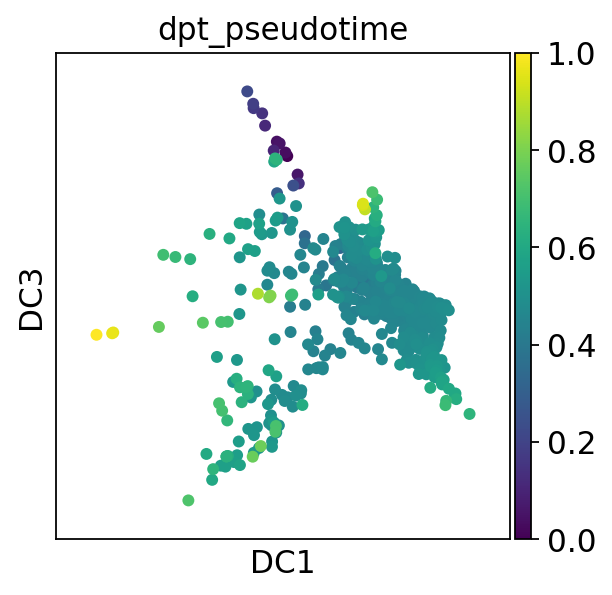

In [29]:
sc.pl.diffmap(adata, components='1,3', color='dpt_pseudotime', save = '_pgc_mycspin_dpt')

In [28]:
# save final result
adata.write(results_file)